# 경향성 시각화 코드

# 1. Library Import

In [1]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt

from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# 2. 데이터 불러오기
> **1) read_csv**

In [2]:
train_x_df = pd.read_csv("./train_x_df.csv")
train_y_df = pd.read_csv("./train_y_df.csv")
test_x_df = pd.read_csv("./test_x_df.csv")

print('train_x_df')
train_x_df.head(5)

train_x_df


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [3]:
totalquote = train_x_df['quote_av']
tbquote = train_x_df['tb_quote_av'] # taker buy quote asset volume
mbquote = totalquote - tbquote # maker buy quote asset volume

mbquote.head(5)

0     5435.449219
1     8352.220703
2        0.000000
3    20499.296875
4    58216.867188
dtype: float64

> **2) numpy array로 변환하기**

In [4]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경
    feature_size = df_2d.iloc[:, 2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:, 2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [5]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [6]:
print(f" train_x_array {train_x_array.shape}\n train_y_array {train_y_array.shape}\n test_x_array {test_x_array.shape}")

 train_x_array (7362, 1380, 10)
 train_y_array (7362, 120, 10)
 test_x_array (529, 1380, 10)


> **3) 샘플 확인하기**

In [7]:
def plot_series(x_series, y_series):
    # 입력 series와 출력 series를 연속적으로 연결해 시각화
    plt.plot(x_series, label='input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)), y_series, label='output_series')
    plt.axhline(1, c='red')
    plt.legend()

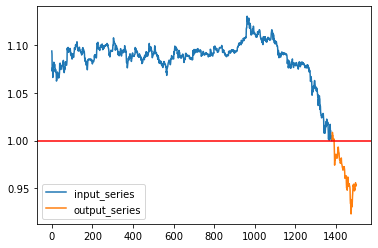

In [8]:
# sample_id 1012에 해당하는 샘플의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

# 3. 모델 훈련하기
> **1) train 샘플 훈련하기**

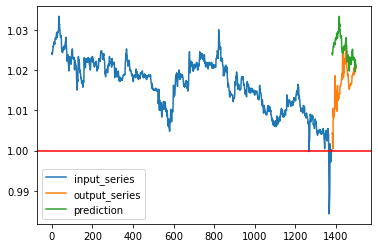

In [9]:
idx = 1121
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습 후
# y_series를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

# ARIMA의 (p,d,q) 값은 최적화되지 않은 값
model = ARIMA(x_series, order=(3,0,1))
fit = model.fit()
preds = fit.predict(1, 120, typ='levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label='prediction')
plt.legend()
plt.show()

> **2-1) validation 데이터 생성하기**

In [10]:
# train 데이터 상단 300개 샘플로 validation set을 구성해 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

> **2-2) 학습 및 추론하기**

In [11]:
# ARIMA의 (p,d,q) 값이 (5,1,1)에서 수렴하지 않을 경우
# (4,1,1)로 변경하여 다시 학습 및 추론
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,1]
            
            model = ARIMA(x_series, order=(5,1,1))
            fit = model.fit()
            preds = fit.predict(1, 120, type='levels')
            valid_pred_array[idx,:] = preds
        except:
            print("order 4 1 1")
            x_series = valid_x_array[idx,:,1]
            
            model = ARIMA(x_series, order=(4,1,1))
            fit = model.fit()
            preds = fit.predict(1, 120, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [03:43<00:00,  1.34it/s]


> **2-3) valid_pred_array로부터 buy_quantity, sell_time 구하기**

In [12]:
def array_to_submission(x_array, pred_array):
    # 입력 x_array와 출력 pred_array를 통해서
    # buy_quantity와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                              columns=['buy_quantity','sell_time'])
    submission = submission.reset_index()
    submission.loc[:,'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    
    # 115% 이상 상승하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:,'buy_quantity'] = (buy_price > 1.15) * 1
    
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns =['sample_id', 'buy_quantity', 'sell_time']
    return submission

In [13]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [14]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,36
1,1,0,24
2,2,0,44
3,3,0,76
4,4,0,95
...,...,...,...
295,295,0,35
296,296,0,1
297,297,1,19
298,298,0,25


In [15]:
# 전체 300가지 sample에 대해
# 9가지 case에서 115% 이상 상승한다고 추론함
valid_submission.buy_quantity.value_counts()

0    291
1      9
Name: buy_quantity, dtype: int64

> **2-4) 투자 후 금액 계산하기**

In [16]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터 open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index



def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id 정보를 index에 저장
    y_array,index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index,:]
    
    # 초기 투자 비용은 10000 달러
    total_money = 10000 # dollars
    total_money_list = []
    
    # 가장 처음 sample_id 값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time = submission.loc[row_idx, 'sell_time']
        buy_price = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_money
        residual = total_money - buy_quantity
        ratio = sell_price / buy_price
        total_money = buy_quantity * ratio * 0.9995 * 0.9995 + residual
        total_money_list.append(total_money)
        
    return total_money, total_money_list

In [17]:
total_money, total_money_list = COIN(valid_y_df, 
                                     valid_submission)

In [18]:
# 투자 후 금액
print(total_money)

10253.164352622545


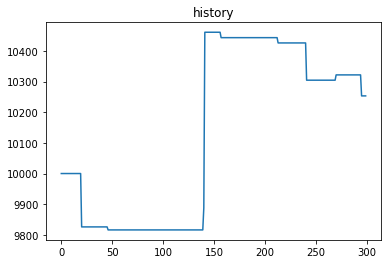

In [19]:
# 투자 히스토리
plt.plot(total_money_list)
plt.title("history")
plt.show()